In [1]:
!pip install ultralytics --quiet

from google.colab import drive
drive.mount('/content/drive')

# Ganti dengan folder tempat model YOLO & ResNet kamu
project_dir = '/content/drive/MyDrive/sawit_project'


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.8 MB/s eta 0:00:00
Mounted at /content/drive


In [24]:
from google.colab import files
uploaded = files.upload()

import os
for filename in uploaded.keys():
    input_path = os.path.abspath(filename)
print(f"\n✅ File berhasil diupload: {input_path}")


Saving Stanh_10.png to Stanh_10.png

✅ File berhasil diupload: /content/Stanh_10.png


In [25]:
import cv2
import numpy as np

# --- LOAD INPUT IMAGE ---
img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)

# --- SPLIT 4 BANDS ---
B, G, R, NIR = cv2.split(img)
R = R.astype(np.float32)
NIR = NIR.astype(np.float32)

# --- COMPUTE NDVI ---
bottom = NIR + R
bottom[bottom == 0] = 0.01
ndvi = (NIR - R) / bottom

# --- NDVI THRESHOLDS ---
NDVI_LOW = 0.11
NDVI_MED = 0.22
NDVI_HIGH = 0.42

# --- CREATE MASK WITH THRESHOLD COLORS ---
mask = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
mask[ndvi < NDVI_LOW] = [0, 0, 255]               # Red = non-vegetation
mask[(ndvi >= NDVI_LOW) & (ndvi < NDVI_MED)] = [0, 255, 255]   # Yellow = unhealthy
mask[(ndvi >= NDVI_MED) & (ndvi < NDVI_HIGH)] = [0, 165, 255]  # Orange = mid
mask[ndvi >= NDVI_HIGH] = [0, 255, 0]              # Green = healthy

# --- BLEND WITH RGB (OPTIONAL, SESUAI KODEMU DULU) ---
B = B.astype(np.uint8)
G = G.astype(np.uint8)
R = R.astype(np.uint8)
rgb = cv2.merge([B, G, R])
ndvi_mask = cv2.addWeighted(rgb, 0.4, mask, 0.6, 0)

# --- SAVE NDVI MASK ---
cv2.imwrite("ndvi_mask.jpg", ndvi_mask)


True

In [26]:
from ultralytics import YOLO

model_yolo = YOLO(f"{project_dir}/MODEL YOLOV8.pt")
results = model_yolo(rgb)[0]
boxes = results.boxes.xyxy.cpu().numpy()



0: 640x640 165 palmtrees, 586.2ms
Speed: 7.9ms preprocess, 586.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


In [27]:
ndvi_img = cv2.imread(ndvi_mask_path)
ndvi_img = cv2.cvtColor(ndvi_img, cv2.COLOR_BGR2RGB)

crops, centers = [], []

for (x1, y1, x2, y2) in boxes:
    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
    crops.append(ndvi_img[y1:y2, x1:x2])
    centers.append(((x1 + x2) // 2, (y1 + y2) // 2))


In [28]:
import torch
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn

model_resnet = models.resnet18()
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 2)
model_resnet.load_state_dict(torch.load(f"{project_dir}/MODEL RESNET 18.pth", map_location='cpu'))
model_resnet.eval()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

labels = []
for crop in crops:
    tensor = transform(crop).unsqueeze(0)
    with torch.no_grad():
        output = model_resnet(tensor)
        labels.append(torch.argmax(output, dim=1).item())


✅ NDVI mask disimpan di: ndvi_mask.jpg
✅ Gambar titik kesehatan disimpan di: hasil_titik_kesehatan.jpg


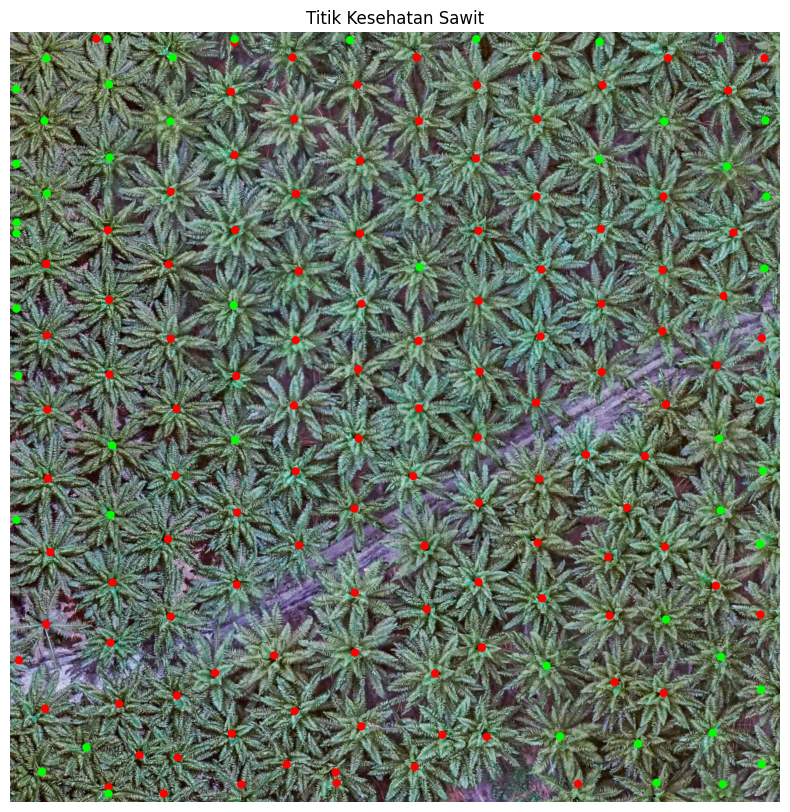

In [29]:
import matplotlib.pyplot as plt

output_img = rgb.copy()
colors = {0: (255, 0, 0), 1: (0, 255, 0)}  # 0=sakit, 1=sehat

for (cx, cy), label in zip(centers, labels):
    cv2.circle(output_img, (cx, cy), 12, colors[label], -1)

hasil_path = "hasil_titik_kesehatan.jpg"
cv2.imwrite(hasil_path, cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR))

print("✅ NDVI mask disimpan di:", ndvi_mask_path)
print("✅ Gambar titik kesehatan disimpan di:", hasil_path)

plt.figure(figsize=(10, 10))
plt.imshow(output_img)
plt.axis('off')
plt.title("Titik Kesehatan Sawit")
plt.show()


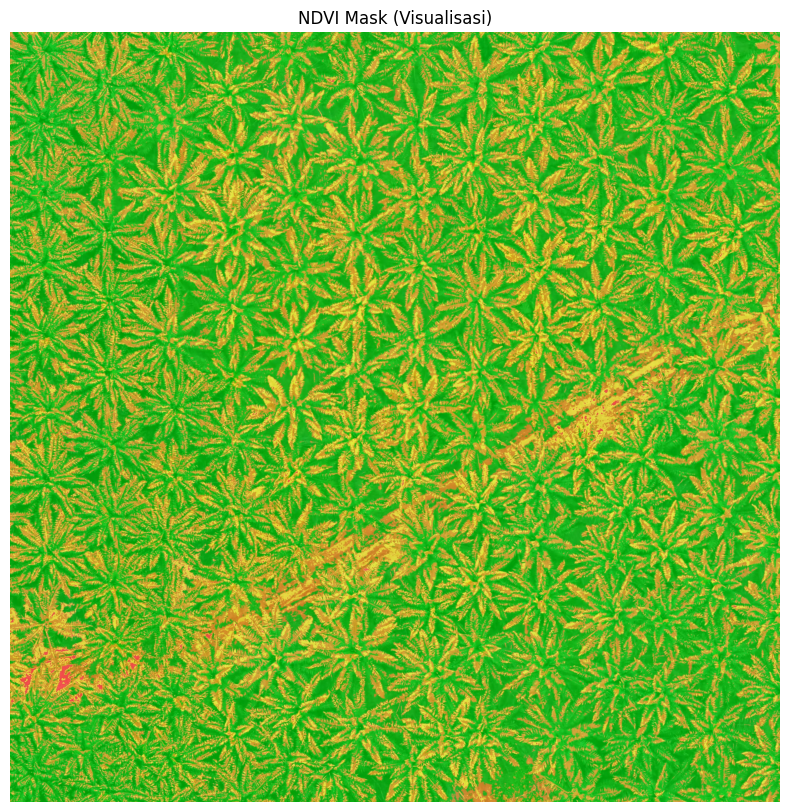

In [30]:
import matplotlib.pyplot as plt
import cv2

ndvi_display = cv2.imread("ndvi_mask.jpg")
ndvi_display = cv2.cvtColor(ndvi_display, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(ndvi_display)
plt.axis("off")
plt.title("NDVI Mask (Visualisasi)")
plt.show()
